# Homework 3

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1. Treasury Futures and Cheapest-to-Deliver

The file `data/fut_bond_data_FVU3_2023-04-21.xlsx` has market data on the following:
* 5-year Treasury future, expiring September 2023
* The specifications of the deliverable treasury bonds

Market quotes are provided on the futures contract and the bond prices. These will be useful for some of the analysis questions, but you do not need them for your models as you are provided a BDT tree which is fit to swaps and caps. See below for more details on this BDT model.

Suppose the present date is `2023-04-21`.

In [112]:
import pandas as pd
import numpy as np
from Binomial_Fixed import binomial, ratecurves
from Binomial_Fixed import ficcvol
from treasury_cmds import *
import scipy
from scipy.optimize import fsolve
from scipy.stats import norm
from datetime import date
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [113]:
future_bonds = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/fut_bond_data_FVU3_2023-04-21.xlsx'
bdt_path = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/bdt_params_freq52_2023-04-21.xlsx'
future_description = pd.read_excel(future_bonds, sheet_name='future')
bond_info = pd.read_excel(future_bonds,sheet_name='bonds')
bdt_params = pd.read_excel(bdt_path)
Future_Price = future_description.iloc[1,1]



In [114]:
DATE = '2023-04-21'
FUT_DAYS_EXPIRE = 159

In [115]:
future_description

,field,FVU3 Comdty
0,last_update_dt,2023-04-21 00:00:00
1,px_last,109.789062
2,last_tradeable_dt,2023-09-29 00:00:00
3,fut_dlv_dt_last,2023-10-04 00:00:00
4,fut_days_expire,159
5,fut_ctd,T 3.875 11/30/27
6,fut_ctd_px,100.757812
7,fut_ctd_gross_basis,-17.074348
8,fut_ctd_net_basis,1.199828


In [116]:
bond_info.head()

,ticker,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
0,91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226
1,91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212
2,91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058
3,91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234
4,91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075


In [117]:
bond_info['cash_price'] = bond_info['px_last'] + .5*bond_info['cpn']*(bond_info['days_acc']/(bond_info['accrued_days_between_cpn_dates']))

In [118]:
def forward_price(spot_price,cpn,repo,days_next_cpn,int_accrued,accrued_days_btwn_dates,DAY_COUNT = 365.25):
    coupon = .5*(cpn)
    repo = repo*(1/100)
    I = int_accrued
    inner = spot_price-coupon*np.exp(-repo*(days_next_cpn/accrued_days_btwn_dates))
    #inner = (spot_price-I)
    return inner*np.exp(repo*(159/365.25))

def carry(cpn,repo, days_acc, days_fwd,accrued_days_between_cpns,DAY_COUNT = 360):
    cpn = .5*cpn
    return (cpn*(days_fwd/accrued_days_between_cpns) - cpn*(days_acc/accrued_days_between_cpns)) - repo*(159/DAY_COUNT)



In [119]:
bond_info['gross_basis'] = bond_info['px_last']-bond_info['conversion']*Future_Price
bond_info['carry'] = (bond_info['cpn']-bond_info['repo_reporate'])*(FUT_DAYS_EXPIRE/365.25)-bond_info['int_acc']

In [120]:
bond_info['gross_basis'] = 32*(bond_info['px_last'] - Future_Price*bond_info['conversion'])
bond_info['net_basis'] = (bond_info['gross_basis'] - bond_info['carry'])

### BDT Model

In this problem you will make use of a BDT modeled binomial tree.

To save you some time, you are provided the parameters of a BDT tree fit to both swaps and caps.
* Use the file `bdt_params_freq52_2023-04-21.xlsx`
* With these $\sigma$ and $\theta$ parameters, you should be able to build a BDT tree with $T=5$ and $dt=1/52$.

#### Note
If interested in how this was done, find the data and files used to get these parameters. In particular, 
* The market quotes interpolated to weekly frequency: `cap_curves_2023-04-21_freq_52.xlsx`.
* The file to estimate the model is `Parameterize BDT.ipynb`.

## 1.1 Trading Bonds

Give brief answers to these based on the market quotes provided,
### 1.1.1
Calculate the 
* gross basis
* carry
* net basis for each bond

### 1.1.2
Which bond seems most likely to be CTD?

### 1.1.3
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

In [121]:
#1.1.1
bond_info.iloc[:,-3:]

,gross_basis,carry,net_basis
0,-17.074450,-1.952812,-15.121638
1,-12.405900,-1.629503,-10.776397
2,-8.051850,-1.374930,-6.676920
3,3.364950,-0.952610,4.317560
4,6.225625,-0.755734,6.981359


## 1.2 Conversion Factors

Calculate the conversion factor for each bond. Report it to `6` decimal places.

Do they match the conversion factor provided by Bloomberg?

In [122]:

tmat = (bond_info['days_to_mty'] - FUT_DAYS_EXPIRE)/365.25
conversion_factor = pd.DataFrame(ratecurves.price_bond(.06,tmat,bond_info['cpn']/(100),cpnfreq = 2,face = 100, accr_frac=0)/100, columns=['Conversion Factor'])
conversion_factor = conversion_factor.merge(bond_info['conversion'], left_index=True, right_index=True)
conversion_factor.index = bond_info['ticker']
converts = ratecurves.price_bond(.06,tmat,bond_info['cpn']/(100),cpnfreq = 2,face = 100, accr_frac=0)/100


In [123]:
conversion_factor

,Conversion Factor,conversion
ticker,,
91282CFZ Govt,0.922669,0.9226
91282CGC Govt,0.921283,0.9212
91282CGH Govt,0.905770,0.9058
91282CGP Govt,0.923408,0.9234
91282CGT Govt,0.907522,0.9075


## 1.3 BDT Tree

Report the number of steps for
* each bond's maturity
* the futures contract expiration

Build the interest-rate tree and display it.

In [124]:
FREQUENCY = 52
def number_steps(num_days, frequency):
    years = num_days/365.25
    tree_steps = round(round(years*frequency)/frequency,6)
    return tree_steps


In [125]:
coupons = number_steps(bond_info['days_to_next_coupon'], frequency=52)
maturities = number_steps(bond_info['days_to_mty'], frequency=52)
Future_Expiry = number_steps(159,frequency=FREQUENCY)
maturities

0    4.596154
1    4.692308
2    4.769231
3    4.846154
4    4.942308
Name: days_to_mty, dtype: float64

In [126]:
for i in maturities:
    print(f'tsteps {int(52*i)}')

tsteps 239
tsteps 244
tsteps 248
tsteps 252
tsteps 257


- Each bond will have 5 time steps

## 1.4 Bond Pricing

Use the tree to price each bond. Report
* time-0 dirty and clean price of each bond
* terminal (clean) value of each bond at futures expiration, for each state of the tree.

Thus, to report the terminal values you will need to grab the expiration column of each bond's (clean) pricing tree and adjust (inflate) it for the conversion factor.

In [127]:
bdt_params = bdt_params.set_index('maturity')

In [128]:
Future_Expiry

0.442308

In [129]:
bdt_params.head()

,discount,fwd vol,theta
maturity,,,
0.019231,0.999060,0.234111,0.426576
0.038462,0.998113,0.234111,0.462743
0.057692,0.997159,0.211844,0.422369
0.076923,0.996200,0.203757,0.358536
0.096154,0.995236,0.201575,0.284977


In [130]:

ratetree=  binomial.BDTtree(bdt_params['theta'],sigmas=bdt_params['fwd vol'],px_bond0=bdt_params['discount'].iloc[0], dt = 1/FREQUENCY)
ratetree.loc[:,:Future_Expiry].head()


time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,...,0.269231,0.288462,0.307692,0.326923,0.346154,0.365385,0.384615,0.403846,0.423077,0.442308
state,,,,,,,,,,,,,,,,,,,,,
0,0.048894,0.050923,0.053074,0.055102,0.057073,0.059013,0.060938,0.062859,0.064785,0.066724,...,0.076833,0.078980,0.081182,0.083446,0.085778,0.088183,0.090670,0.093245,0.095916,0.098691
1,NaN,0.047722,0.049737,0.051638,0.053485,0.055303,0.057107,0.058908,0.060712,0.062529,...,0.072003,0.074015,0.076079,0.078200,0.080385,0.082639,0.084970,0.087383,0.089886,0.092487
2,NaN,NaN,0.046610,0.048391,0.050122,0.051827,0.053517,0.055204,0.056896,0.058598,...,0.067476,0.069362,0.071296,0.073284,0.075331,0.077444,0.079628,0.081889,0.084235,0.086673
3,NaN,NaN,NaN,0.045630,0.047262,0.048869,0.050463,0.052054,0.053649,0.055254,...,0.063626,0.065404,0.067227,0.069102,0.071033,0.073025,0.075084,0.077217,0.079429,0.081727
4,NaN,NaN,NaN,NaN,0.044666,0.046184,0.047691,0.049194,0.050701,0.052218,...,0.060130,0.061810,0.063534,0.065305,0.067130,0.069013,0.070959,0.072974,0.075064,0.077236


In [131]:
FV = 100
compound = FREQUENCY
dt = 1/compound
cpn_freq = 2

In [132]:
terminal_values = pd.DataFrame(dtype=float, index = ratetree.index, columns = bond_info.index)
px_bonds = pd.DataFrame(dtype=float, index =bond_info.index , columns=['clean_price'])
px_dirty = pd.DataFrame(dtype = float, index = bond_info.index, columns=['Dirty_Price'])

In [133]:
for idx, bond in enumerate(bond_info.index):
    print(bond_info.loc[bond,'cpn'])

3.875
3.875
3.5
4.0
3.625


In [134]:
for idx, bond in enumerate(bond_info.index):
    time_steps = round(maturities[idx]/dt)
    cpn = bond_info.loc[bond,'cpn']/100

    wrapper_function = lambda rate : binomial.payoff_bond(rate, dt, facevalue=FV*(1+cpn/cpn_freq))

    cftree = binomial.construct_bond_cftree(maturities[idx], compound = compound, cpn = cpn)
    if coupons[idx] == 0:
        cftree.loc[0,0] += cpn/2

    bondtree = binomial.bintree_pricing(payoff=wrapper_function, ratetree=ratetree.iloc[:time_steps,:time_steps],cftree=cftree)
    accrued_int_tree = binomial.construct_accint(timenodes=bondtree.columns.values,freq = compound, cpn = cpn)
    #dirty_tree = bondtree+accrued_int_tree
    px_dirty.loc[bond] = bondtree.iloc[0,0] 
    clean_tree = np.maximum(bondtree - accrued_int_tree,0)
    px_bonds.loc[bond] = clean_tree.iloc[0,0]
    terminal_values[bond] = clean_tree[Future_Expiry]


In [135]:
bond_info

,ticker,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion,cash_price,gross_basis,carry,net_basis
0,91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226,102.301425,-17.074450,-1.952812,-15.121638
1,91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212,101.970304,-12.405900,-1.629503,-10.776397
2,91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058,99.997799,-8.051850,-1.374930,-6.676920
3,91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234,102.082201,3.364950,-0.952610,4.317560
4,91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075,100.065830,6.225625,-0.755734,6.981359


In [136]:
px_bonds

,clean_price
0,100.715335
1,100.739787
2,99.142046
3,101.320874
4,99.686176


In [137]:
px_dirty

,Dirty_Price
0,102.280239
1,101.932095
2,99.949739
3,101.936259
4,99.895311


In [138]:
bondtree.head()

time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,...,4.750000,4.769231,4.788462,4.807692,4.826923,4.846154,4.865385,4.884615,4.903846,4.923077
state,,,,,,,,,,,,,,,,,,,,,
0,99.895311,98.727797,97.487076,96.170555,94.775408,93.299222,91.739985,90.096121,88.366552,86.550751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,101.250771,100.161981,99.002701,97.769627,96.459753,95.070348,93.598996,92.043648,90.402680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,102.525489,101.512961,100.432499,99.280730,98.054445,96.750634,95.366532,93.899674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,103.721899,102.782449,101.777977,100.705016,99.560193,98.340271,97.042197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,104.843464,103.973843,103.042331,102.045394,100.979544,99.841370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
bond_info['px_last']

0    100.757812
1    100.750000
2     99.195312
3    101.484375
4     99.828125
Name: px_last, dtype: float64

In [140]:
terminal_values = terminal_values.dropna()


## 1.5 CTD

Use your terminal values calculated above to state which bond is CTD in each interest-rate state (at this expiration node.) 

Report the duration of each bond (as of today's price, not recomputed for the interest-rate nodes.) Do you see a relationship between the time-0 duration and the at-expiration CTD?

In [141]:
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

In [142]:
bond_info

,ticker,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion,cash_price,gross_basis,carry,net_basis
0,91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226,102.301425,-17.074450,-1.952812,-15.121638
1,91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212,101.970304,-12.405900,-1.629503,-10.776397
2,91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058,99.997799,-8.051850,-1.374930,-6.676920
3,91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234,102.082201,3.364950,-0.952610,4.317560
4,91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075,100.065830,6.225625,-0.755734,6.981359


In [144]:
Future_Price*conversion_factor['Conversion Factor'].values

array([101.29896327, 101.14684537,  99.44368169, 101.38014068,
        99.63593948])

In [145]:
t_values = terminal_values - Future_Price*conversion_factor['Conversion Factor'].values

In [147]:
cdts = terminal_values.style.apply(highlight_min,axis = 1)
cdts

,0,1,2,3,4
state,,,,,
0,54.190817,53.679552,52.200684,53.266976,51.715786
1,59.713179,59.213908,57.692757,58.834005,57.236961
2,65.156443,64.681234,63.129166,64.351855,62.721681
3,70.434948,69.994864,68.423046,69.732352,68.081659
4,75.475907,75.080452,73.499272,74.898803,73.239460
5,80.219954,79.876688,78.295346,79.786970,78.129611
6,84.623048,84.337375,82.763592,84.347387,82.701043
7,88.656832,88.431952,86.871808,88.546139,86.918019
8,92.307822,92.144841,90.602748,92.364436,90.759862


In [165]:
bondstats = pd.DataFrame(dtype=float, index = bond_info.index, columns=['ticker','px_last','cpn','ytm','duration','conversion'])
for idx, bond in enumerate(bond_info.index):
    T = bond_info.loc[idx,'days_to_mty']/365.25
    bondstats.loc[bond,'ticker'] = bond_info.loc[bond,'ticker']
    cpn =bond_info.loc[bond,'cpn']/100
    bondstats.loc[idx,'cpn'] = cpn
    accfrac = bond_info.loc[bond,'days_acc']/bond_info.loc[bond,'accrued_days_between_cpn_dates']
    bondstats.loc[bond,'px_last'] = bond_info.loc[bond,'px_last']
    p = bond_info.loc[bond,'px_last']
    bondstats.loc[bond,'conversion'] = bond_info.loc[bond,'conversion']
    bondstats.loc[bond,'ytm'] = ratecurves.ytm(p,T = T, cpn = cpn,cpnfreq=2,face = 100,accr_frac=accfrac)
    bondstats.loc[bond,'duration'] = ratecurves.duration_closed_formula(tau = T, ytm = bondstats.loc[bond,'ytm'],cpnrate=cpn,freq = 2)



In [166]:
bondstats

,ticker,px_last,cpn,ytm,duration,conversion
0,91282CFZ Govt,100.757812,0.03875,0.040795,4.257591,0.9226
1,91282CGC Govt,100.750000,0.03875,0.039922,4.329998,0.9212
2,91282CGH Govt,99.195312,0.03500,0.038884,4.432692,0.9058
3,91282CGP Govt,101.484375,0.04000,0.037915,4.459884,0.9234
4,91282CGT Govt,99.828125,0.03625,0.037173,4.563210,0.9075


## 1.6 Futures Price

Model the futures price with the tree approach.
* Use the CTD terminal value for each rate.
* Step backward through the tree.

As you step backward remember that for a futures contract
* no discounting by the riskfree rate
* the futures contract has no capital requirement and thus an expected P&L of zero under this measure.

Thus, each node is the simple average of the two nodes at the following step.

**Report the futures price.**

### Compare
How does it compare to 
* the quoted futures price
* the modeled bond prices

In [167]:
converts

0    0.922669
1    0.921283
2    0.905770
3    0.923408
4    0.907522
dtype: float64

In [168]:
payoff_func = lambda rate: (terminal_values/converts).min(axis = 1).values
ratetree_fwd_measure = ratetree.copy().loc[:,:Future_Expiry].dropna(how = 'all')
ratetree_fwd_measure *= 0 
future_tree = binomial.bintree_pricing(payoff=payoff_func,ratetree=ratetree_fwd_measure)
future_tree.head()

time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,...,0.269231,0.288462,0.307692,0.326923,0.346154,0.365385,0.384615,0.403846,0.423077,0.442308
state,,,,,,,,,,,,,,,,,,,,,
0,109.733681,108.483577,107.146463,105.717779,104.192974,102.567635,100.837666,98.999555,97.050700,94.989779,...,83.079495,80.413661,77.669611,74.854741,71.976973,69.045180,66.069144,63.059492,60.027637,56.985739
1,NaN,110.983785,109.820690,108.575147,107.242583,105.818314,104.297603,102.675777,100.948410,99.111620,...,88.240055,85.745330,83.157711,80.484480,77.732509,74.908765,72.021216,69.078796,66.091347,63.069535
2,NaN,NaN,112.146879,111.066233,109.907712,108.666853,107.339025,105.919430,104.403143,102.785200,...,93.029135,90.734780,88.332949,85.830941,83.236451,80.556253,77.796314,74.963636,72.066245,69.113160
3,NaN,NaN,NaN,113.227525,112.224754,111.148570,109.994681,108.758619,107.435717,106.021086,...,97.391946,95.323490,93.136611,90.834958,88.425430,85.916649,83.316192,80.628992,77.861027,75.019331
4,NaN,NaN,NaN,NaN,114.230297,113.300938,112.302460,111.230743,110.081521,108.850349,...,101.291408,99.460402,97.510370,95.438264,93.244485,90.934212,88.517106,86.003392,83.396958,80.702724


In [169]:
future_comps = pd.DataFrame({'Quote':[Future_Price],'Model':[future_tree.iloc[0,0]]},index = ['Price'])
future_comps

,Quote,Model
Price,109.789062,109.733681


In [170]:
quality = terminal_values.copy().divide(converts,axis = 1)
quality.index = ratetree.loc[:,Future_Expiry].dropna()
quality.columns = bond_info.ticker
quality

ticker,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
0.442308,,,,,
0.098691,58.732674,58.266055,57.631254,57.685177,56.985739
0.092487,64.717878,64.273279,63.694682,63.713960,63.069535
0.086673,70.617355,70.207746,69.696654,69.689486,69.113160
0.081727,76.338263,75.975385,75.541271,75.516265,75.019331
0.077236,81.801717,81.495497,81.145590,81.111245,80.702724
0.073037,86.943373,86.701534,86.440612,86.404857,86.091191
0.069043,91.715501,91.543352,91.373701,91.343536,91.128463
0.065205,96.087365,95.987780,95.909305,95.890552,95.775158
0.061496,100.044353,100.017907,100.028384,100.025555,100.008493


In [171]:
quality.style.highlight_min(color = 'green', axis = 1)

ticker,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
0.442308,,,,,
0.098691,58.732674,58.266055,57.631254,57.685177,56.985739
0.092487,64.717878,64.273279,63.694682,63.713960,63.069535
0.086673,70.617355,70.207746,69.696654,69.689486,69.113160
0.081727,76.338263,75.975385,75.541271,75.516265,75.019331
0.077236,81.801717,81.495497,81.145590,81.111245,80.702724
0.073037,86.943373,86.701534,86.440612,86.404857,86.091191
0.069043,91.715501,91.543352,91.373701,91.343536,91.128463
0.065205,96.087365,95.987780,95.909305,95.890552,95.775158
0.061496,100.044353,100.017907,100.028384,100.025555,100.008493


In [172]:
bondstats

,ticker,px_last,cpn,ytm,duration,conversion
0,91282CFZ Govt,100.757812,0.03875,0.040795,4.257591,0.9226
1,91282CGC Govt,100.750000,0.03875,0.039922,4.329998,0.9212
2,91282CGH Govt,99.195312,0.03500,0.038884,4.432692,0.9058
3,91282CGP Govt,101.484375,0.04000,0.037915,4.459884,0.9234
4,91282CGT Govt,99.828125,0.03625,0.037173,4.563210,0.9075


In [173]:
bond_comps = pd.concat([bond_info['px_last'], px_bonds], axis=1).rename(columns={'px_last':'Quote','clean_price':'Model'})
bond_comps_converted = bond_comps.copy().divide(converts,axis = 0)
fut_vs_bonds = pd.concat([future_comps,bond_comps_converted],axis = 0)
fut_vs_bonds

,Quote,Model
Price,109.789062,109.733681
0,109.202557,109.156519
1,109.358310,109.347224
2,109.514855,109.456047
3,109.901942,109.724880
4,110.000832,109.844419


In [175]:
bond_comps_converted

,Quote,Model
0,109.202557,109.156519
1,109.358310,109.347224
2,109.514855,109.456047
3,109.901942,109.724880
4,110.000832,109.844419


## 1.7 Early Delivery
**Optional**
Above we modeled the terminal value at the futures expiration. Now consider if early delivery would be better.

Which periods in the tree are eligible to deliver based on the parameters of the 5-year futures contract? 

Based on your model, does it make sense to deliver early in any of the nodes of the tree?

## 1.8 Option-Adjusted Spread
**Optional**

Calculate and report the option-adjusted spread (OAS) for the future.

Note that you
* do NOT need to recalculate the bond prices
* will simply add a constant rate (at every node) for discounting the futures price in the previous problem.

What does the OAS indicate?

***

# 2. Fed Funds Futures

The file `data/fedfutures_2023-04-21.xlsx`jj has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2024.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2023-04-21`.

In [176]:
fed_file = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/fedfutures_2023-04-21.xlsx'
fed_futures = pd.read_excel(fed_file, sheet_name = 'fed futures')
fed_funds = pd.read_excel(fed_file,sheet_name='fed funds')
fed_futures_historic = pd.read_excel(fed_file,sheet_name='fed futures historic')
fed_meetings = pd.read_excel(fed_file,sheet_name='fed meetings')
fed_futures_historic


,ticker,2022-10-25 00:00:00
0,FFJ3 Comdty,95.105
1,FFK3 Comdty,95.085
2,FFM3 Comdty,95.100
3,FFN3 Comdty,95.115
4,FFQ3 Comdty,95.155
5,FFU3 Comdty,95.175
6,FFV3 Comdty,95.220
7,FFX3 Comdty,95.330
8,FFZ3 Comdty,95.395
9,FFF4 Comdty,95.435


## 2.1 Chart the Fed Futures Rates

Chart the Fed Funds curve at
* the present date
* the historic date

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

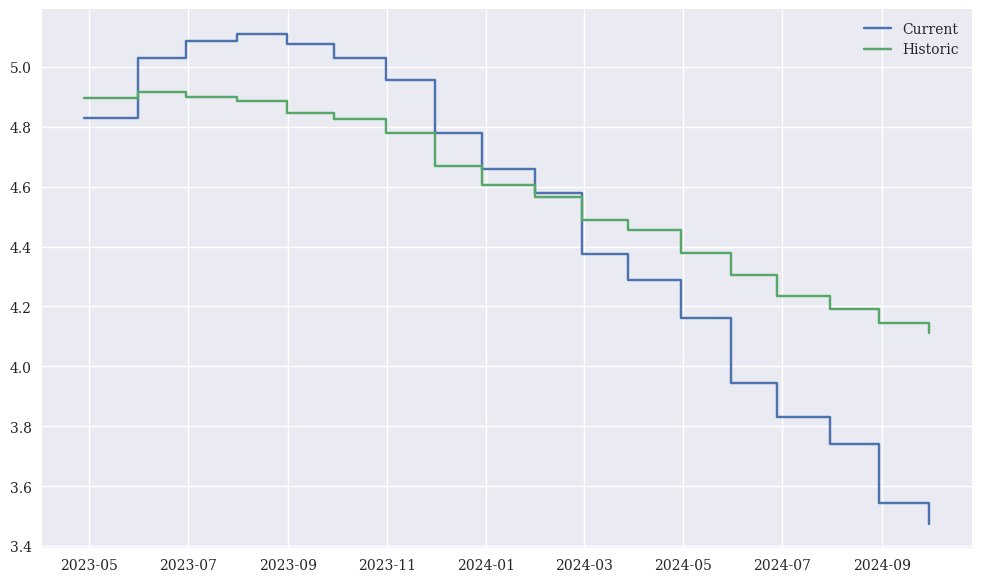

In [177]:
plt.figure(figsize = (12,7))
plt.step(fed_futures['last_tradeable_dt'],100-fed_futures['px_last'],where = 'post', label = 'Current')
plt.step(fed_futures['last_tradeable_dt'] , 100 - fed_futures_historic.iloc[:,1], where = 'post',label = "Historic")

plt.legend(loc = 0)

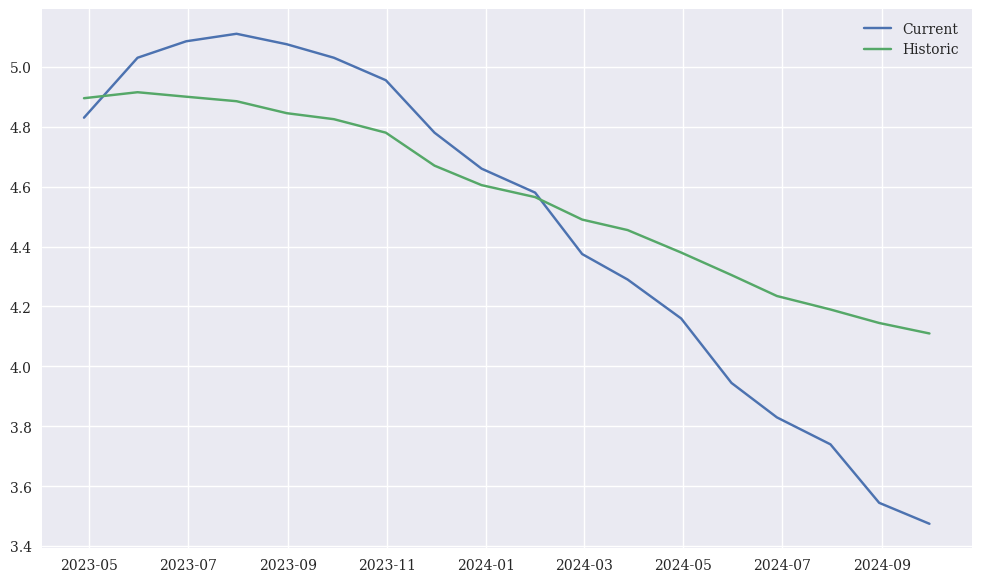

In [178]:
plt.figure(figsize = (12,7))
plt.plot(fed_futures['last_tradeable_dt'],100-fed_futures['px_last'], label = 'Current')
plt.plot(fed_futures['last_tradeable_dt'] , 100 - fed_futures_historic.iloc[:,1], label = "Historic")
plt.legend(loc = 0)

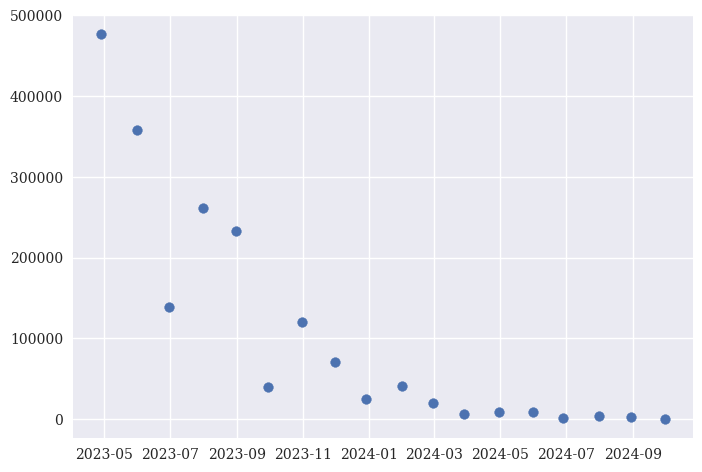

In [179]:
plt.scatter(fed_futures['last_tradeable_dt'],fed_futures['open_int'])

- The STIR futures with the most open interest are ones that mature in the front end because they are the most liquid and traded. 

## 2.2 Extracting the Expected Path of Fed Funds Rates

The Fed has a great deal of control over the Fed Funds Rate. We simplify by assuming the Fed 
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Note
One (minor) assumption:
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.
* Here, use the simpler method #1--that is, for months with no meeting in the following month, the calculation is very simple.

## 2.3 Compare to the Historic Curve

Use the price data in the historic tab to extract the expectations at the previous date.
* Note that you do not need to "bootstrap" up from the historic date to the current date. 
* There was no meeting in the current month, so its futures price is enough to get started.

Compare this to the answer in the previous problem, for the current data.

## 2.4 Analyzing the Expected Path

These questions are both conceptual--no calculation required.

### 2.4.1
Conceptually, is the path extracted above the **expected path**? In what sense is it or is it not?

### 2.4.2

Probability Distributions

The implied path above is not representative of any single actual path of Fed rates, which are typically changed by 25bps at a time.

Conceptually, what would you need to make probability statements about the Fed moving rates up/down by 25bps on any given meeting date? For instance, as seen in the `probabilities` tab of the [CME FedWatch Tool](https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html)?

Do not quantitatively solve this--just a conceptual answer is fine.

***